# GNS on the 2D Taylor Green Vortex
This tutorial notebook will show how to train a GNS model on the 2D Taylor Green Vortex. It will give a brief overview of LagrangeBench on these topics:
- Datasets and case setup
- Models
- Training tricks and strategies (noise-walk and pushforward)
- Training and inference

In [ ]:
import lagrangebench

## Datasets
First thing to do is to load the dataset. The simplest way to do this is by using the `lagrangebench.data.TGV2D` class. It will automatically download the HDF5 files if they are not found in the respective folder, and it will take care of setting up the dataset. Note that for the validation set `is_rollout=True`. This means that the dataset will not split the trajectory into subsequences and keep whole rollouts for evaluation.

In [2]:
tgv2d_train = lagrangebench.data.TGV2D("train")
tgv2d_eval = lagrangebench.data.TGV2D("valid", is_rollout=True)

print(
    f"This is a {tgv2d_train.metadata['dim']}D dataset "
    f"called {tgv2d_train.metadata['case']}.\n"
    f"Train snapshot have shape {tgv2d_train[0][0].shape} (n_nodes, seq_len, xy pos).\n"
    f"Val snapshot have shape {tgv2d_eval[0][0].shape} (n_nodes, rollout, xy pos).\n"
)

This is a 2D dataset called TGV.
Train snapshot have shape (2500, 7, 2) (n_nodes, seq_len, xy pos).
Val snapshot have shape (2500, 126, 2) (n_nodes, rollout, xy pos).



Similarly, for other datasets one can use the respective subclass, for example
```python
rpf_3d_data = lagrangebench.data.RPF3D("train") # 3D Reverse Poiseuille Flow
dam_2d_data = lagrangebench.data.DAM2D("train") # 2D Dambreak
# etc.
# and in general: 
lagrangebench.data.H5Dataset("train", dataset_path="path/to/dataset")
```

## Models
Models instances can be created either with the model constructor or through the `lagrangebench.models.get_model` helper. All the models will have a similar structure, inheriting from [`models.BaseModel`](/lagrangebench/models/base.py) and generally needing a `_transform` function for feature engineering and building the graph. 

Here we use a small GNS model, with 32 latent dimension and 5 message passing layers and predicting 2D accelerations. Note that we use a function wrapper beause `haiku.Modules` must be initialized inside `hk.transform`.


In [3]:
def gns(x):
    return lagrangebench.models.GNS(
        particle_dimension=tgv2d_train.metadata["dim"],
        latent_size=16,
        num_mlp_layers=2,
        num_message_passing_steps=4,
        particle_type_embedding_size=8,
    )(x)


# equivalent to
# gns, _ = lagrangebench.get_model(
#     "gns", data_train.metadata, latent_dim=16, num_mp_steps=4, num_mlp_layers=2
# )

Then apply `haiku.transform` to the model function

In [4]:
import haiku as hk

gns = hk.without_apply_rng(hk.transform_with_state(gns))

## Training tricks and strategies
To improve performance and stabilize training we can use a number of tricks and strategies. In this notebook we will cover noise-walk and pushforward, which are included by default in LagrangeBench. 

### Noise-walk
Briefly, noise-walk adds noise to the velocities in the input sequence and adjusts the target positions accordingly. The standard deviation is passed as a parameter, and each noise step is rescaled so that the cumulated noise has the input standard deviation. It applied to GNNs in physics in the ["Learning to Simulate Complex Physics with Graph Networks"](https://arxiv.org/abs/2002.09405) paper (2020).

### Pushforward
Instead of training always on the next step, the pushforward trick will randomly sample a number of "unroll" steps to perform and compute the loss only on the last one. Ideally this should inject the "right amount" of noise, since it comes from the physical distribution. Because it adds some overhead, the maximum number of unroll steps should not be too large and the probability of unrolling large sequences should be reasonably small. It comes from the ["Message Passing Neural PDE Solvers"](https://arxiv.org/pdf/2202.03376.pdf) paper (2022).

In [5]:
noise_std = 1e-5

pf_config = lagrangebench.PushforwardConfig(
    steps=[0, 5000, 10000],  # training steps to unlock the relative stage
    unrolls=[0, 2, 5],  # number of unroll steps per stage
    probs=[7, 2, 1],  # probabilities to unroll to the relative stage
)

For example, this configuration would apply noise with `std=1e-5` and the pushforward trick with three unroll stages (0, 2 and 5), "unlocking" the second stage after 5000 training steps and the third stage after 10000 training steps. After 10000 steps, 0-step unroll (normal training) will happen with a probability of 70%, 2-step unroll with a probability of 20% and finally 5-step unroll with a probability of 10%.

## Case
The `CaseSetupFn` is an essential part in LagrangeBench. Most of the operations during training, such as data preprocessing, time integration for the ouput and neighbor computation are managed by `CaseSetupFn`. The easies way to initialize it is through the `lagrangebench.case_builder` function.

In [6]:
import numpy as np

bounds = np.array(tgv2d_train.metadata["bounds"])
box = bounds[:, 1] - bounds[:, 0]

tgv2d_case = lagrangebench.case_builder(
    box=box,  # (x,y) array with the world size along each axis. (1.0, 1.0) for 2D TGV
    metadata=tgv2d_train.metadata,  # metadata dictionary
    input_seq_length=6,  # number of consecutive time steps fed to the model
    isotropic_norm=False,  # whether to normalize each dimension independently
    noise_std=noise_std,  # noise standard deviation used by the noise-walk
)

## Training and inference
Finally, to train GNS on Taylor Green (with noise and pushforward) the `lagrangebench.Trainer` methods comes to hand

In [7]:
trainer = lagrangebench.Trainer(
    model=gns,
    case=tgv2d_case,
    dataset_train=tgv2d_train,
    dataset_eval=tgv2d_eval,
    noise_std=noise_std,
    metrics=["mse"],
    n_rollout_steps=20,
    eval_n_trajs=1,
    lr_start=5e-4,
    log_steps=1000,
    eval_steps=5000,
)

params, state, _ = trainer(step_max=25000)

00000, train/loss: 1.41759.
01000, train/loss: 0.00346.
02000, train/loss: 0.16304.
03000, train/loss: 0.00283.
04000, train/loss: 0.19889.
05000, train/loss: 1.62106.
{'val/loss': 0.0018766636494547129, 'val/mse5': 3.6450819607125595e-05, 'val/mse10': 0.00023817359760869294, 'val/stdloss': 0.0, 'val/stdmse5': 0.0, 'val/stdmse10': 0.0}
06000, train/loss: 0.02196.
07000, train/loss: 0.01039.
08000, train/loss: 0.00945.
09000, train/loss: 0.90057.
10000, train/loss: 0.09890.
{'val/loss': 0.0025816201232373714, 'val/mse5': 3.4340537240495905e-05, 'val/mse10': 0.0002786243858281523, 'val/stdloss': 0.0, 'val/stdmse5': 0.0, 'val/stdmse10': 0.0}
11000, train/loss: 0.02635.
12000, train/loss: 0.01136.
13000, train/loss: 0.00529.
14000, train/loss: 0.00094.
15000, train/loss: 0.00161.
{'val/loss': 0.0009246250847354531, 'val/mse5': 2.6636624170350842e-05, 'val/mse10': 0.00014887377619743347, 'val/stdloss': 0.0, 'val/stdmse5': 0.0, 'val/stdmse10': 0.0}
16000, train/loss: 0.00669.
17000, train/lo

Now let's see what the trained GNS can do. First, let's get the test data. As for the validation set, `is_rollout=True` so that the dataset does not split the trajectory into subsequences.

In [8]:
tgv2d_test = lagrangebench.TGV2D("test", is_rollout=True)

Then let's run then evaluation over 20 timesteps. Here we use three evaluation metrics: __position MSE__ and __Sinkhorn__ distance.

In [9]:
import pickle

metrics = lagrangebench.infer(
    gns,
    tgv2d_case,
    tgv2d_test,
    params,
    state,
    metrics=["mse", "sinkhorn"],
    eval_n_trajs=1,
    n_rollout_steps=20,
    rollout_dir="rollouts/",
    out_type="pkl",
)["rollout_0"]
rollout = pickle.load(open("rollouts/rollout_0.pkl", "rb"))

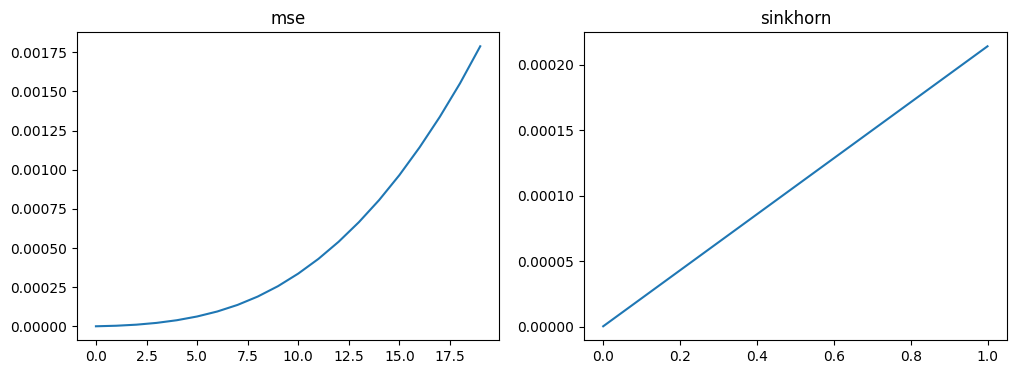

In [10]:
import matplotlib.pyplot as plt

# plot metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot the metrics
for i, m in enumerate(["mse", "sinkhorn"]):
    ax[i].plot(metrics[m])
    ax[i].set_title(m)

In [18]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

print(f"rollout of shape {rollout['predicted_rollout'].shape} (steps, nodes, xy pos)")

fig, ax = plt.subplots(1, 2)
ax[0].set_xlim([0, 1.0])
ax[0].set_ylim([0, 1.0])
ax[1].set_xlim([0, 1.0])
ax[1].set_ylim([0, 1.0])
fig.set_size_inches(10, 5, forward=True)
ax[0].set_title("GNS")
ax[1].set_title("Ground Truth")

rollout_len = rollout["predicted_rollout"].shape[0] - 1

scat0 = ax[0].scatter(
    rollout["predicted_rollout"][0, :, 0], rollout["predicted_rollout"][0, :, 1]
)
scat1 = ax[1].scatter(
    rollout["ground_truth_rollout"][0, :, 0], rollout["ground_truth_rollout"][0, :, 1]
)


def animate(i):
    scat0.set_offsets(rollout["predicted_rollout"][i])
    scat1.set_offsets(rollout["ground_truth_rollout"][i])
    return scat0, scat1


ani = animation.FuncAnimation(
    fig, animate, repeat=True, frames=rollout_len, interval=50
)

plt.close(fig)

writer = animation.PillowWriter(fps=10, metadata=dict(artist="Me"), bitrate=1800)
ani.save("media/scatter.gif", writer=writer)

from IPython.display import Image

Image(url="media/scatter.gif")

rollout of shape (26, 2500, 2) (steps, nodes, xy pos)


![Alternative gif for github](notebooks/media/scatter.gif)